# Mount One Drive

In [ ]:
# mount google drive to colab
from google.colab import drive
import os

n = 140
drive.mount('/content/drive')
print("#" * n)

# change working directory
print("### colabs default working directory")

print("###\n### path: {}".format(os.getcwd()))
print("#" * n)
print("### setted working directory")

%cd drive/Shareddrives/MADS_Milestone2/


print("###\n### {}".format(os.getcwd()))
print("#" * n)

Mounted at /content/drive
############################################################################################################################################
### colabs default working directory
###
### path: /content
############################################################################################################################################
### setted working directory
/content/drive/Shareddrives/MADS_Milestone2
###
### /content/drive/Shareddrives/MADS_Milestone2
############################################################################################################################################


# Create a physical protein-protein network

## Import libraries

In [ ]:
from platform import python_version
import sys
import pandas as pd
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

print("used python version {}".format(python_version()))

used python version 3.7.12


# STRING DB
- these are the resources from which STRING DB extracts its experimental data BIND, DIP, GRID, HPRD, IntAct, MINT, and PID.
- these are the resources from which STRING DB extracts its curated data Biocarta, BioCyc, GO, KEGG, and Reactome
- consider protein.links.txt scores are multiplyied by 1000 and then truncated. therefore 872 in the file means a STRING score of 0.872

Download physical protein protein interactions

In [ ]:
!wget --directory-prefix=/content/drive/Shareddrives/MADS_Milestone2/dat/ https://stringdb-static.org/download/protein.links.full.v11.5/9606.protein.links.full.v11.5.txt.gz
!wget --directory-prefix=/content/drive/Shareddrives/MADS_Milestone2/dat/ https://stringdb-static.org/download/protein.physical.links.full.v11.5/9606.protein.physical.links.full.v11.5.txt.gz
!wget --directory-prefix=/content/drive/Shareddrives/MADS_Milestone2/dat/ https://stringdb-static.org/download/protein.info.v11.5/9606.protein.info.v11.5.txt.gz


## load a lookup table to convert ensembl protein id to gene symbols

The keys (#string_protein_id) are enembl-protein ids instead of entrezID - we need to convert it to entrez id

In [ ]:
info = pd.read_csv("dat/9606.protein.info.v11.5.txt.gz", compression='gzip', header=0, sep='\t', quotechar='"')

In [ ]:
info["protein_id"] = info["#string_protein_id"].str.split(".", expand=True)[1]
info.rename(columns={"preferred_name": "protein_symbol"}, inplace=True)

lookup = info.set_index("protein_id")["protein_symbol"].to_dict()

NameError: ignored

## load the full network of protein interactions - will also contain genetic interactions not only physical

In [ ]:
tmp = pd.read_csv("dat/9606.protein.links.full.v11.5.txt.gz", compression='gzip', header=0, sep=' ', quotechar='"')
tmp.head()

,protein1,protein2,neighborhood,neighborhood_transferred,fusion,cooccurence,homology,coexpression,coexpression_transferred,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
0,9606.ENSP00000000233,9606.ENSP00000379496,0,0,0,0,0,0,54,0,0,0,0,103,85,155
1,9606.ENSP00000000233,9606.ENSP00000314067,0,0,0,0,0,0,0,0,180,0,0,0,61,197
2,9606.ENSP00000000233,9606.ENSP00000263116,0,0,0,0,0,0,62,0,152,0,0,0,101,222
3,9606.ENSP00000000233,9606.ENSP00000361263,0,0,0,0,0,0,0,0,161,0,0,47,58,181
4,9606.ENSP00000000233,9606.ENSP00000409666,0,0,0,0,0,60,63,0,213,0,0,0,72,270


In [ ]:
"There are {}Mio edges in the STRING DB".format(round(len(tmp) / 1000000, 1))

'There are 11.9Mio edges in the STRING DB'

## import the dataset that is mentioned to contain only physical interactions - to see if we are missing something

In [ ]:
tmp = pd.read_csv("dat/9606.protein.physical.links.full.v11.5.txt.gz", compression='gzip', header=0, sep=' ', quotechar='"')
tmp.head()

,protein1,protein2,homology,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
0,9606.ENSP00000000233,9606.ENSP00000264718,0,0,157,0,0,0,0,156
1,9606.ENSP00000000233,9606.ENSP00000346046,0,0,178,0,0,0,0,177
2,9606.ENSP00000000233,9606.ENSP00000347134,0,0,143,0,0,0,63,162
3,9606.ENSP00000000233,9606.ENSP00000317469,0,0,345,0,0,0,92,379
4,9606.ENSP00000000233,9606.ENSP00000302393,0,272,62,0,0,0,0,287


In [ ]:
"There are {}Mio edges in the STRING DBconsidering only phsical interactions".format(round(len(tmp) / 1000000, 1))

'There are 2.0Mio edges in the STRING DBconsidering only phsical interactions'

In [ ]:
# clean node ids remove the homo sapiens code id
p1 = tmp.protein1.str.split(".", expand=True)
p2 = tmp.protein2.str.split(".", expand=True)

new = p1.merge(p2, how="inner", left_index=True, right_index=True)


## check if the interactions in this table are real physical interactions

In [ ]:
# in this example i looked at IL13 = ENSP00000304915 cytokine which should bind to IL4RA IL13RA1 IL13RA2
IL13 = tmp[new.isin(["ENSP00000304915"]).sum(axis=1).replace({1: True, 0: False})]
IL13[IL13.experiments > 0]

,protein1,protein2,homology,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
624703,9606.ENSP00000304915,9606.ENSP00000360730,0,933,0,600,0,769,639,997
624709,9606.ENSP00000304915,9606.ENSP00000361004,0,933,86,800,0,663,642,998
624715,9606.ENSP00000304915,9606.ENSP00000457492,0,270,0,0,0,0,0,270
624723,9606.ENSP00000304915,9606.ENSP00000379111,0,892,0,600,0,881,0,994
1187335,9606.ENSP00000360730,9606.ENSP00000304915,0,933,0,600,0,769,639,997
1192711,9606.ENSP00000361004,9606.ENSP00000304915,0,933,86,800,0,663,642,998
1461493,9606.ENSP00000379111,9606.ENSP00000304915,0,892,0,600,0,881,0,994
1855362,9606.ENSP00000457492,9606.ENSP00000304915,0,270,0,0,0,0,0,270


I have learned something new. there is experimental evidence that ENSP00000457492 = TMEM219 dimerize with IL13RA2 and binds to IL13 but its not visible via STRINGDB gui -  what is going wrong here? Is this because we don t see a score under database?

test another one - this time we look at at CXCL10 a chemokine which is induced by IFNg and binds its receptor CXCR3. However, it was also showin to be an competetive antagonist on CCR3 against CCL11

In [ ]:
# test another one - this time we look at at CXCL10 = ENSP00000305651 a chemokine which is induced by IFNg and binds its receptor CXCR3. However, it was also showin to be an 
# competetive antagonist on CCR3 against CCL11
cxcl10 = tmp[new.isin(["ENSP00000305651"]).sum(axis=1).replace({1: True, 0: False})]
cxcl10[cxcl10.experiments > 0]

,protein1,protein2,homology,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
94973,9606.ENSP00000225844,9606.ENSP00000305651,0,271,0,0,0,0,0,271
99248,9606.ENSP00000226317,9606.ENSP00000305651,0,270,0,0,0,0,0,270
99544,9606.ENSP00000226524,9606.ENSP00000305651,0,237,0,0,0,0,0,237
250494,9606.ENSP00000259607,9606.ENSP00000305651,0,293,0,0,0,0,60,307
538769,9606.ENSP00000296028,9606.ENSP00000305651,0,270,0,0,0,251,0,429
538784,9606.ENSP00000296029,9606.ENSP00000305651,0,237,0,900,0,0,0,920
601243,9606.ENSP00000302234,9606.ENSP00000305651,0,270,0,900,0,0,0,923
629314,9606.ENSP00000305651,9606.ENSP00000259607,0,293,0,0,0,0,60,307
629316,9606.ENSP00000305651,9606.ENSP00000472467,0,237,0,0,0,0,0,237
629321,9606.ENSP00000305651,9606.ENSP00000302234,0,270,0,900,0,0,0,923


--> there are a lot of potential interactions
--> i would try to focus on physical interactions which are experimently proven with a score about ~ 400 = 0.4 (Experiments)

In [ ]:
cxcl10[cxcl10.experiments > 400] # --> looks much more confident

,protein1,protein2,homology,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
629347,9606.ENSP00000305651,9606.ENSP00000362795,0,483,0,900,0,898,89,994
629354,9606.ENSP00000305651,9606.ENSP00000353731,0,480,0,0,0,221,0,577
1041393,9606.ENSP00000353731,9606.ENSP00000305651,0,480,0,0,0,221,0,577
1238731,9606.ENSP00000362795,9606.ENSP00000305651,0,483,0,900,0,898,89,994


In [ ]:
IL13[IL13.experiments > 400] # --> looks much more confident

,protein1,protein2,homology,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
624703,9606.ENSP00000304915,9606.ENSP00000360730,0,933,0,600,0,769,639,997
624709,9606.ENSP00000304915,9606.ENSP00000361004,0,933,86,800,0,663,642,998
624723,9606.ENSP00000304915,9606.ENSP00000379111,0,892,0,600,0,881,0,994
1187335,9606.ENSP00000360730,9606.ENSP00000304915,0,933,0,600,0,769,639,997
1192711,9606.ENSP00000361004,9606.ENSP00000304915,0,933,86,800,0,663,642,998
1461493,9606.ENSP00000379111,9606.ENSP00000304915,0,892,0,600,0,881,0,994


In [ ]:
# check another one - if the interactions with CCL17 are real physical interactions
# this example i looked at CCL17 = ENSP00000219244 cytokine which should bind to CCR4 and CCR8
CCL17 = tmp[new.isin(["ENSP00000219244"]).sum(axis=1).replace({1: True, 0: False})]
display(CCL17[CCL17.experiments > 0])
CCL17[CCL17.experiments > 400]

,protein1,protein2,homology,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
60798,9606.ENSP00000219244,9606.ENSP00000259607,0,237,54,0,0,0,0,247
60799,9606.ENSP00000219244,9606.ENSP00000378365,0,237,0,0,0,0,0,237
60801,9606.ENSP00000219244,9606.ENSP00000294728,0,270,0,0,0,0,0,270
60803,9606.ENSP00000219244,9606.ENSP00000326432,0,463,0,0,0,706,0,835
60804,9606.ENSP00000219244,9606.ENSP00000375086,0,220,54,0,0,0,0,230
60805,9606.ENSP00000219244,9606.ENSP00000472467,0,237,0,0,0,77,0,265
60808,9606.ENSP00000219244,9606.ENSP00000332659,0,506,56,0,0,696,0,845
60811,9606.ENSP00000219244,9606.ENSP00000337065,0,237,0,0,0,0,0,237
60812,9606.ENSP00000219244,9606.ENSP00000292303,0,280,56,0,0,0,0,291
60813,9606.ENSP00000219244,9606.ENSP00000354416,0,273,0,0,0,0,0,273


,protein1,protein2,homology,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
60803,9606.ENSP00000219244,9606.ENSP00000326432,0,463,0,0,0,706,0,835
60808,9606.ENSP00000219244,9606.ENSP00000332659,0,506,56,0,0,696,0,845
790138,9606.ENSP00000326432,9606.ENSP00000219244,0,463,0,0,0,706,0,835
830725,9606.ENSP00000332659,9606.ENSP00000219244,0,506,56,0,0,696,0,845


## clean ensembl protein keys

In [ ]:
tmp["protein1"] = tmp["protein1"].str.split(".", expand=True)[1]
tmp["protein2"] = tmp["protein2"].str.split(".", expand=True)[1]
tmp

,protein1,protein2,homology,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
0,ENSP00000000233,ENSP00000264718,0,0,157,0,0,0,0,156
1,ENSP00000000233,ENSP00000346046,0,0,178,0,0,0,0,177
2,ENSP00000000233,ENSP00000347134,0,0,143,0,0,0,63,162
3,ENSP00000000233,ENSP00000317469,0,0,345,0,0,0,92,379
4,ENSP00000000233,ENSP00000302393,0,272,62,0,0,0,0,287
...,...,...,...,...,...,...,...,...,...,...
1991827,ENSP00000485672,ENSP00000295065,0,0,159,0,0,0,0,158
1991828,ENSP00000485672,ENSP00000367263,0,0,161,0,0,0,0,161
1991829,ENSP00000485672,ENSP00000341189,0,0,0,0,0,0,189,189
1991830,ENSP00000485672,ENSP00000435412,0,0,211,0,0,0,0,211


In [ ]:
tmp = tmp[tmp.experiments >= 400].copy()
tmp["protein_symbol1"] = tmp.protein1
tmp["protein_symbol2"] = tmp.protein2
tmp

,protein1,protein2,homology,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score,protein_symbol1,protein_symbol2
185,ENSP00000000233,ENSP00000440005,0,679,0,0,0,225,0,740,ENSP00000000233,ENSP00000440005
295,ENSP00000000233,ENSP00000262305,0,483,76,0,0,156,48,564,ENSP00000000233,ENSP00000262305
325,ENSP00000000233,ENSP00000452762,0,550,58,0,0,0,0,557,ENSP00000000233,ENSP00000452762
415,ENSP00000000233,ENSP00000484121,0,483,80,0,0,0,101,535,ENSP00000000233,ENSP00000484121
491,ENSP00000000412,ENSP00000341344,0,483,0,0,0,685,0,830,ENSP00000000412,ENSP00000341344
...,...,...,...,...,...,...,...,...,...,...,...,...
1991788,ENSP00000485663,ENSP00000348849,0,800,147,600,0,0,0,925,ENSP00000485663,ENSP00000348849
1991795,ENSP00000485663,ENSP00000435096,0,842,164,600,0,0,0,942,ENSP00000485663,ENSP00000435096
1991801,ENSP00000485663,ENSP00000272317,0,800,182,600,0,0,0,928,ENSP00000485663,ENSP00000272317
1991802,ENSP00000485663,ENSP00000270625,0,800,147,600,0,0,0,925,ENSP00000485663,ENSP00000270625


In [ ]:
tmp.replace({"protein_symbol1": lookup, "protein_symbol2": lookup}, inplace=True)
tmp


,protein1,protein2,homology,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score,protein_symbol1,protein_symbol2
185,ENSP00000000233,ENSP00000440005,0,679,0,0,0,225,0,740,ARF5,ARF1
295,ENSP00000000233,ENSP00000262305,0,483,76,0,0,156,48,564,ARF5,RAB11FIP3
325,ENSP00000000233,ENSP00000452762,0,550,58,0,0,0,0,557,ARF5,ETFA
415,ENSP00000000233,ENSP00000484121,0,483,80,0,0,0,101,535,ARF5,ARFIP2
491,ENSP00000000412,ENSP00000341344,0,483,0,0,0,685,0,830,M6PR,GGA1
...,...,...,...,...,...,...,...,...,...,...,...,...
1991788,ENSP00000485663,ENSP00000348849,0,800,147,600,0,0,0,925,EIF3L,RPS26
1991795,ENSP00000485663,ENSP00000435096,0,842,164,600,0,0,0,942,EIF3L,RPS25
1991801,ENSP00000485663,ENSP00000272317,0,800,182,600,0,0,0,928,EIF3L,RPS27A
1991802,ENSP00000485663,ENSP00000270625,0,800,147,600,0,0,0,925,EIF3L,RPS11


export preprocessed data

In [ ]:
tmp.to_csv("res/processed_protein_protein_interactions.csv")

## clean preprocessed data for integration
- rename columns for consitency and generalization
- convert the proteinIDs to entrezID for integration

read in preprocessed data

In [ ]:
pp = pd.read_csv("res/processed_protein_protein_interactions.csv")
pp.shape

(132518, 13)

In [ ]:
pp["node1_type"] = "protein"
pp["node2_type"] = "protein"
pp.rename(columns={"protein1": "node1", "protein2": "node2", "protein_symbol1": "node1_name", "protein_symbol2": "node2_name"}, inplace=True)
pp

,Unnamed: 0,node1,node2,homology,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score,node1_name,node2_name,node1_type,node2_type
0,185,ENSP00000000233,ENSP00000440005,0,679,0,0,0,225,0,740,ARF5,ARF1,protein,protein
1,295,ENSP00000000233,ENSP00000262305,0,483,76,0,0,156,48,564,ARF5,RAB11FIP3,protein,protein
2,325,ENSP00000000233,ENSP00000452762,0,550,58,0,0,0,0,557,ARF5,ETFA,protein,protein
3,415,ENSP00000000233,ENSP00000484121,0,483,80,0,0,0,101,535,ARF5,ARFIP2,protein,protein
4,491,ENSP00000000412,ENSP00000341344,0,483,0,0,0,685,0,830,M6PR,GGA1,protein,protein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132513,1991788,ENSP00000485663,ENSP00000348849,0,800,147,600,0,0,0,925,EIF3L,RPS26,protein,protein
132514,1991795,ENSP00000485663,ENSP00000435096,0,842,164,600,0,0,0,942,EIF3L,RPS25,protein,protein
132515,1991801,ENSP00000485663,ENSP00000272317,0,800,182,600,0,0,0,928,EIF3L,RPS27A,protein,protein
132516,1991802,ENSP00000485663,ENSP00000270625,0,800,147,600,0,0,0,925,EIF3L,RPS11,protein,protein


## use mygene API to convert gene convention

In [ ]:
try:
    import mygene
except ModuleNotFoundError as err:
    !pip install mygene
    import mygene
    # Error handling
    print(err)
 
mg = mygene.MyGeneInfo()
out = mg.querymany(set(list(set(pp.node1))+list(set(pp.node2))), scopes='ensembl.protein', fields='entrezgene', species='human', returnall=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-11263...done.
Finished.
268 input query terms found no hit:
	['ENSP00000357068', 'ENSP00000380635', 'ENSP00000451411', 'ENSP00000265023', 'ENSP00000344909', 'ENS


There are 268 proteins which could not be converted. How many protein where found but could not find an entrezID

In [ ]:
ensp_nonmatched = [i["query"] for i in out["out"] if "entrezgene" not in i.keys()]
len(ensp_nonmatched)-len(out["missing"]), len(ensp_nonmatched), len(out["missing"])

(25, 293, 268)

there are another 25 that might be matched via the protein symbol.

Try to match the missing 268 + the 25 (=293) proteins using the gene symbol names

In [ ]:
 out_miss = mg.querymany(set(pp[pp.isin(out["missing"] + ensp_nonmatched ).loc[:,"node1"]].node1_name), scopes='symbol', fields='entrezgene', species='human', returnall=True) 


querying 1-293...done.
Finished.
12 input query terms found dup hits:
	[('DUX4L5', 2), ('DUX4L8', 4), ('GLRA4', 2), ('DUX4L7', 2), ('DUX4L3', 2), ('DUX4L1', 2), ('DUX4L2',
43 input query terms found no hit:
	['ENSG00000248405', 'MICALCL', 'ENSG00000213599', 'EP400NL', 'AIM1', 'ENSG00000260836', 'ENSG0000025


In [ ]:
len(out_miss["out"])

309

In [ ]:
out_miss["missing"]

['ENSG00000248405',
 'MICALCL',
 'ENSG00000213599',
 'EP400NL',
 'AIM1',
 'ENSG00000260836',
 'ENSG00000255730',
 'ENSG00000273049',
 'ENSG00000259040',
 'ADCK3',
 'ENSG00000132716',
 'C10orf12',
 'ENSG00000249624',
 'ENSG00000273637',
 'C17orf102',
 'ENSG00000026036',
 'ENSG00000263620',
 'ENSG00000272752',
 'PRSS46',
 'AHSA2',
 'ENSG00000267318',
 'ENSG00000273398',
 'C10orf25',
 'ENSG00000255819',
 'RT14',
 'OBBP2',
 'ENSG00000197584',
 'TCP10',
 'ENSG00000244255',
 'ENSG00000258674',
 'C2orf27B',
 'JHDM3C',
 'ENSG00000273217',
 'ENSG00000279392',
 'ENSG00000257184',
 'ENSG00000267881',
 'GATS',
 'ENSG00000239789',
 'ENSG00000264813',
 'ENSG00000262660',
 'FYB',
 'C2orf48',
 'WRB']

This helped a lot. Now there are only 43 missing proteins and 12 duplicated matches.
try to match the missing 43 proteins manually

In [ ]:
 # manually match and convert the missing values
 mis_conv = [
             {"entrezgene": "50717", "query": "ENSG00000132716", "symbol": "DCAF8"},             
             {"entrezgene": "400591", "query": "C17orf102", "symbol": "TMEM132E-DT"},
             {"entrezgene": "ENSG00000249624", "query": "ENSG00000249624", "symbol": "ENSG00000249624"},
             {"entrezgene": "100287362", "query":"PRSS46", "symbol": "PRSS46P"},
             {"entrezgene": "ENSG00000244255", "query": "ENSG00000244255", "symbol": "ENSG00000244255"},
             {"entrezgene": "ENSG00000263620", "query": "ENSG00000263620", "symbol": "ENSG00000263620"},
             {"entrezgene": "2647", "query": "RT14", "symbol": "BLOC1S1"},
             {"entrezgene": "ENSG00000260836", "query": "ENSG00000260836", "symbol": "ENSG00000260836"},
             {"entrezgene": "ENSG00000267318", "query": "ENSG00000267318", "symbol": "ENSG00000267318"},             
             {"entrezgene": "51373", "query": "ENSG00000239789", "symbol": "MRPS17"},             
             {"entrezgene": "ENSG00000262660", "query": "ENSG00000262660", "symbol": "ENSG00000262660"},
             {"entrezgene": "ENSG00000257184", "query": "ENSG00000257184", "symbol": "ENSG00000257184"},
             {"entrezgene": "10242", "query": "ENSG00000197584", "symbol": "KCNMB2"},
             {"entrezgene": "56997", "query": "ADCK3", "symbol": "COQ8A"},
             {"entrezgene": "ENSG00000273049", "query": "ENSG00000273049", "symbol": "ENSG00000273049"},
             {"entrezgene": "ENSG00000273217", "query": "ENSG00000273217", "symbol": "ENSG00000273217"},
             {"entrezgene": "ENSG00000258674", "query": "ENSG00000258674", "symbol": "ENSG00000258674"},
             {"entrezgene": "ENSG00000255730", "query": "ENSG00000255730", "symbol": "ENSG00000255730"},
             {"entrezgene": "100526830", "query":"ENSG00000213599", "symbol": "SLX1A-SULT1A3"},
             {"entrezgene": "553158", "query":"ENSG00000248405", "symbol": "PRR5-ARHGAP8"},
             {"entrezgene": "23081", "query":"JHDM3C", "symbol": "KDM4C"},
             {"entrezgene": "ENSG00000264813", "query":"ENSG00000264813", "symbol": "ENSG00000264813"},
             {"entrezgene": "352954", "query":"GATS", "symbol": "CASTOR3"},
             {"entrezgene": "6953", "query":"TCP10", "symbol": "TCP10L3"},
             {"entrezgene": "100533107", "query":"ENSG00000026036", "symbol": "RTEL1-TNFRSF6B"},
             {"entrezgene": "6241", "query":"C2orf48", "symbol": "RRM2"},
             {"entrezgene": "2533", "query":"FYB", "symbol": "FYB1"},
             {"entrezgene": "100528032", "query":"ENSG00000255819", "symbol": "KLRC4-KLRK1"},
             {"entrezgene": "347918", "query":"EP400NL", "symbol": "EP400P1"},
             {"entrezgene": "84458", "query":"C10orf12", "symbol": "LCOR"},
             {"entrezgene": "ENSG00000279392", "query":"ENSG00000279392", "symbol": "UBE2L3"},
             {"entrezgene": "ENSG00000273398", "query":"ENSG00000273398", "symbol": "ENSG00000273398"},
             {"entrezgene": "84953", "query":"MICALCL", "symbol": "MICALCL"},
             {"entrezgene": "ENSG00000267881", "query":"ENSG00000267881", "symbol": "CEACAM5-CEACAM6"},
             {"entrezgene": "ENSG00000277704", "query":"C2orf27B", "symbol": "ENSG00000277704"},
             {"entrezgene": "ENSG00000273637", "query":"ENSG00000273637", "symbol": "ENSG00000273637"},
             {"entrezgene": "202", "query":"AIM1", "symbol": "CRYBG1"},
             {"entrezgene": "7485", "query":"WRB", "symbol": "GET1"},
             {"entrezgene": "8778", "query":"OBBP2", "symbol": "SIGLEC5"},
             {"entrezgene": "220979 ", "query":"C10orf25", "symbol": "ZNF22-AS1"},
             {"entrezgene": "100526836", "query":"ENSG00000259040", "symbol": "BLOC1S5-TXNDC5"},
             {"entrezgene": "101752399", "query":"ENSG00000272752", "symbol": "STAG3L5P-PVRIG2P-PILRB"},
             {"entrezgene": "130872", "query": "AHSA2", "symbol": "AHSA2P"}
             ]
len(mis_conv)

43

now i still need to deal with the 12 duplicates. choose manualy by checking in [gene card](https://www.genecards.org/) which one is the correct match

In [ ]:
# get all the protein names of the duplicated matches
l = [i[0] for i in out_miss["dup"]]
# get the whole query results of the duplicated matches
dup = [i for i in out_miss["out"] if i["query"] in l]

# choose via gene card which match was the right one https://www.genecards.org/
print(out_miss["dup"])
# HBD = 3045
# DUX4L1 = 22947
# DUX4L8 = 26583
# DUX4L2 = 728410
# DUX4L5 = 653545
# DUX4L3 = 653548
# DUX4L4 = 441056
# DUX4L6 = 653544 
# GLRA4 =  441509
# DUX4L7 = 653543
# PKD1P1 = 339044
# TCP10L2 = 401285

dup_conv = [f for f in [d for d in dup if "entrezgene" in d.keys()] if f["entrezgene"] != "100187828"]
len(dup_conv)

[('DUX4L5', 2), ('DUX4L8', 4), ('GLRA4', 2), ('DUX4L7', 2), ('DUX4L3', 2), ('DUX4L1', 2), ('DUX4L2', 3), ('DUX4L6', 2), ('PKD1P1', 3), ('HBD', 2), ('DUX4L4', 2), ('TCP10L2', 2)]


12

In [ ]:
len(mis_conv)

43

In [ ]:
n = 140
print("#"*n)
print("### Second match via protein Symbols\n" + "#"*n )
print("Total number of miss matched protein conversion: {}".format(len(out_miss["out"])))
tmp = [i for i in out_miss["out"] if i["query"] not in l]
rem = [i for i in out_miss["out"] if i["query"] in l]
print("removed all {} duplicated matches. There are {} proteins remaining - which are missing".format(len(rem),len(tmp)))
rem = [i for i in tmp if "notfound" in i.keys()]
TMP = [i for i in tmp if "notfound" not in i.keys()]
print("removed all {} not found matches. There are {} proteins remaining".format(len(rem), len(tmp)))
tmp = pp[pp.isin([g["query"] for g in TMP]).node1_name].set_index("node1_name").loc[:,"node1" ].to_dict()
for f in TMP:
  f["query"] = tmp[f["query"]]

# replace the query to the ensembl.protein id so we can replace it later 
tmp = pp[pp.isin([g["query"] for g in dup_conv]).node1_name].set_index("node1_name").loc[:,"node1" ].to_dict()
for f in dup_conv:
  f["query"] = tmp[f["query"]]

# replace the query to the ensembl.protein id so we can replace it later 
tmp = pp[pp.isin([g["query"] for g in mis_conv]).node1_name].set_index("node1_name").loc[:,"node1" ].to_dict()
for f in mis_conv:
  f["query"] = tmp[f["query"]]

tmp = TMP + dup_conv + mis_conv
print("added all {} manually matches proteins. Resulting with all {} initially missed matches. Now we need to bring it back to the main list".format(len(mis_conv)+len(dup_conv), len(tmp)))

print("#"*n)
print("### First match via protein ensembl.protein - bring the manualy miss matched hits back \n" + "#"*n )

print("Total number of miss matched protein conversion in first attemp via ensembl.protein: {}".format(len(out["missing"])+len(ensp_nonmatched)-len(out["missing"])))
conv = [i for i in out["out"] if "entrezgene" in i.keys()]
rem = [i["query"] for i in out["out"] if "entrezgene" not in i.keys()] 
print("removed all {} not found matches. There are {} proteins remaining".format(len(rem), len(conv)))
conv = conv + tmp
print("added all {} manually matched proteins. Resulting with the complete conversion list {}".format(len(tmp), len(conv)))


############################################################################################################################################
### Second match via protein Symbols
############################################################################################################################################
Total number of miss matched protein conversion: 309
removed all 28 duplicated matches. There are 281 proteins remaining - which are missing
removed all 43 not found matches. There are 281 proteins remaining
[{'query': 'ENSP00000451107', '_id': '653545', '_score': 41.287952, 'entrezgene': '653545'}, {'query': 'ENSP00000485452', '_id': '26583', '_score': 39.81849, 'entrezgene': '26583'}, {'query': 'ENSP00000361700', '_id': '441509', '_score': 31.07722, 'entrezgene': '441509'}, {'query': 'ENSP00000451411', '_id': '653543', '_score': 41.287952, 'entrezgene': '653543'}, {'query': 'ENSP00000451859', '_id': '653548', '_score': 41.287952, 'entrezgene': '653548'}, {'query': 'ENSP0

In [ ]:
# check if i correctly changed all queries to ensembl.protein
look = {c["query"]: c["entrezgene"] for c in conv}
len([i for i in list(look.keys()) if i[:3] != "ENS"])


0

In [ ]:
# pp.rename(columns= {"node1": "node1_ensembl.protein", 
#            "node2": "node2_ensembl.protein"}, inplace=True)
pp["node1_ensembl.protein"] = pp["node1"]
pp["node2_ensembl.protein"] = pp["node2"]
pp["color"] = "blue"
pp["shape"] = "o"
pp.replace({"node1": look, "node2": look}, inplace=True)
pp


,Unnamed: 0,node1,node2,homology,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score,node1_name,node2_name,node1_type,node2_type,node1_ensembl.protein,node2_ensembl.protein
0,185,381,375,0,679,0,0,0,225,0,740,ARF5,ARF1,protein,protein,ENSP00000000233,ENSP00000440005
1,295,381,9727,0,483,76,0,0,156,48,564,ARF5,RAB11FIP3,protein,protein,ENSP00000000233,ENSP00000262305
2,325,381,2108,0,550,58,0,0,0,0,557,ARF5,ETFA,protein,protein,ENSP00000000233,ENSP00000452762
3,415,381,23647,0,483,80,0,0,0,101,535,ARF5,ARFIP2,protein,protein,ENSP00000000233,ENSP00000484121
4,491,4074,26088,0,483,0,0,0,685,0,830,M6PR,GGA1,protein,protein,ENSP00000000412,ENSP00000341344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132513,1991788,51386,6231,0,800,147,600,0,0,0,925,EIF3L,RPS26,protein,protein,ENSP00000485663,ENSP00000348849
132514,1991795,51386,6230,0,842,164,600,0,0,0,942,EIF3L,RPS25,protein,protein,ENSP00000485663,ENSP00000435096
132515,1991801,51386,6233,0,800,182,600,0,0,0,928,EIF3L,RPS27A,protein,protein,ENSP00000485663,ENSP00000272317
132516,1991802,51386,6205,0,800,147,600,0,0,0,925,EIF3L,RPS11,protein,protein,ENSP00000485663,ENSP00000270625


In [ ]:
pp.loc[:,["node1", "node2", "node1_name", "node2_name", "node1_type", "node2_type", "node1_ensembl.protein", "node2_ensembl.protein", "color", "shape"]].to_csv("res/final_protein_protein_interaction_network.csv")

In [ ]:
pp = pd.read_csv("res/final_protein_protein_interaction_network.csv",index_col=0)
pp

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,node1,node2,node1_name,node2_name,node1_type,node2_type,node1_ensembl.protein,node2_ensembl.protein,color,shape
0,381,375,ARF5,ARF1,protein,protein,ENSP00000000233,ENSP00000440005,blue,o
1,381,9727,ARF5,RAB11FIP3,protein,protein,ENSP00000000233,ENSP00000262305,blue,o
2,381,2108,ARF5,ETFA,protein,protein,ENSP00000000233,ENSP00000452762,blue,o
3,381,23647,ARF5,ARFIP2,protein,protein,ENSP00000000233,ENSP00000484121,blue,o
4,4074,26088,M6PR,GGA1,protein,protein,ENSP00000000412,ENSP00000341344,blue,o
...,...,...,...,...,...,...,...,...,...,...
132513,51386,6231,EIF3L,RPS26,protein,protein,ENSP00000485663,ENSP00000348849,blue,o
132514,51386,6230,EIF3L,RPS25,protein,protein,ENSP00000485663,ENSP00000435096,blue,o
132515,51386,6233,EIF3L,RPS27A,protein,protein,ENSP00000485663,ENSP00000272317,blue,o
132516,51386,6205,EIF3L,RPS11,protein,protein,ENSP00000485663,ENSP00000270625,blue,o


In [ ]:
# specifiy disease of interest - serves as lookup to convert disease id with disease abrebiations
# disease = {"AD": "C0011615", "Pso": "C0033860", "RA": "C0003873", "IBD": "C0010346", "Vitiligo": "C0042900" }

# generate an empty dataframe / Graph as container/placeholder
df = pd.DataFrame()
G = nx.Graph()

# # loop through all diseases to get the nodes
# for k,v in disease.items():
#     tmp = DF["c_gda"][DF["c_gda"].diseaseId == v]
#     tmp["disease"] = k
#     df = pd.concat([df, tmp])

# insert all edges into the empty graph with selected attributes
G = nx.from_pandas_edgelist(pp, 'protein_symbol1', 'protein_symbol2', 
                            edge_attr=['protein1', 'protein2', 'homology',	'experiments',	'experiments_transferred',	'database',
                                       'database_transferred',	'textmining',	'textmining_transferred',	'combined_score'])

# define node attributes
attrs = {r["protein_symbol"]: {"color": "blue", 
                               "shape": "o", 
                               "ensemblPID": r["protein_id"], 
                               "protein_name": r["annotation"], 
                               "size": "protein_size"} 
         for i,r in info.iterrows()}


# insert all node attributes
nx.set_node_attributes(G, attrs)
                                                                         

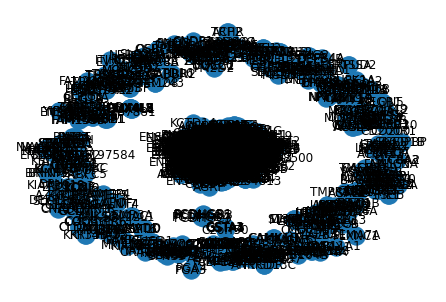

In [ ]:
nx.draw(G, with_labels=True)
plt.show()

## count how many isolated networks there are

In [ ]:
print("There are {} communities".format(len(list(nx.connected_components(G)))))
display(pd.Series([len(c) for c in nx.connected_components(G)]).value_counts())

There are 234 communities


2        186
3         30
4         12
5          2
10721      1
9          1
7          1
6          1
dtype: int64

No need to look at BioGrid becuase its part of STRINGDB

# BioGrid

In [ ]:
!wget --directory-prefix=/content/drive/Shareddrives/MADS_Milestone2/dat/ https://downloads.thebiogrid.org/File/BioGRID/Release-Archive/BIOGRID-4.4.202/BIOGRID-ALL-4.4.202.tab3.zip

In [ ]:
tmp = pd.read_csv("dat/BIOGRID-ALL-4.4.202.tab3.zip", compression='zip', header=0, sep='\t', quotechar='"')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
pp = tmp[((tmp.loc[:,"Organism Name Interactor A"] == "Homo sapiens") & (tmp.loc[:,"Experimental System Type"] == "physical"))
        ].query('`Organism Name Interactor A` == `Organism Name Interactor B`')

In [ ]:
df = pd.DataFrame()
G2 = nx.Graph()

g_dis=nx.get_node_attributes(G,'entrezID')

indA = [v for k,v in g_dis.items() if v in pp.loc[:,"Entrez Gene Interactor A"].tolist()]
indB = [v for k,v in g_dis.items() if v in pp.loc[:,"Entrez Gene Interactor B"].tolist()]

part1 = pp.set_index("Entrez Gene Interactor A").loc[indA,:].reset_index()
part2 = pp.set_index("Entrez Gene Interactor B").loc[indB,:].reset_index()
protein = part1.append(part2)
protein["index"] = list(range(len(protein)+1,  len(protein)*2+1,1))
PRO = pd.concat([protein.loc[:,["Official Symbol Interactor A","Entrez Gene Interactor A"]].rename(columns={"Official Symbol Interactor A": "Official Symbol Interactor", 
                                                                                          "Entrez Gene Interactor A": "Entrez Gene Interactor"}), protein.loc[:,["Official Symbol Interactor B","Entrez Gene Interactor B", "index"]].set_index("index").rename(columns={"Official Symbol Interactor B": "Official Symbol Interactor", 
                                                                                          "Entrez Gene Interactor B": "Entrez Gene Interactor"})]
               ).drop_duplicates(subset=['Entrez Gene Interactor'])


    
G2 = nx.from_pandas_edgelist(PRO, 'geneSymbol', 'disease', 
                            edge_attr=['score', 'EI', 'YearInitial', 'YearFinal', 'NofPmids', 'NofSnps', 'source'])


                                                                         

NameError: ignored

In [ ]:
g_dis=nx.get_node_attributes(G,'entrezID')

indA = [v for k,v in g_dis.items() if v in pp.loc[:,"Entrez Gene Interactor A"].tolist()]
indB = [v for k,v in g_dis.items() if v in pp.loc[:,"Entrez Gene Interactor B"].tolist()]

part1 = pp.set_index("Entrez Gene Interactor A").loc[indA,:].reset_index()
part2 = pp.set_index("Entrez Gene Interactor B").loc[indB,:].reset_index()
protein = part1.append(part2)
protein["index"] = list(range(len(protein)+1,  len(protein)*2+1,1))
PRO = pd.concat([protein.loc[:,["Official Symbol Interactor A","Entrez Gene Interactor A", "Systematic Name Interactor A", "Synonyms Interactor A", "SWISS-PROT Accessions Interactor A",
                              "TREMBL Accessions Interactor A", "REFSEQ Accessions Interactor A"]

                            ].rename(columns={"Official Symbol Interactor A": "Official Symbol Interactor",
                                              "Entrez Gene Interactor A": "Entrez Gene Interactor",
                                             "Systematic Name Interactor A": "Systematic Name Interactor",
                                             "Synonyms Interactor A": "Synonyms Interactor",
                                             "SWISS-PROT Accessions Interactor A": "SWISS-PROT Accessions Interactor", 
                                             "TREMBL Accessions Interactor A": "TREMBL Accessions Interactor",
                                             "REFSEQ Accessions Interactor A": "REFSEQ Accessions Interactor"}),

                 protein.loc[:,["Official Symbol Interactor B","Entrez Gene Interactor B", "index", "Systematic Name Interactor B", "Synonyms Interactor B", 
                                "SWISS-PROT Accessions Interactor B", "TREMBL Accessions Interactor B", "REFSEQ Accessions Interactor B"]
                            ].set_index("index").rename(columns={"Official Symbol Interactor B": "Official Symbol Interactor",
                                                                 "Entrez Gene Interactor B": "Entrez Gene Interactor",
                                                                 "Systematic Name Interactor B": "Systematic Name Interactor",
                                                                 "Synonyms Interactor B": "Synonyms Interactor",
                                                                 "SWISS-PROT Accessions Interactor B": "SWISS-PROT Accessions Interactor", 
                                                                 "TREMBL Accessions Interactor B": "TREMBL Accessions Interactor",
                                                                 "REFSEQ Accessions Interactor B": "REFSEQ Accessions Interactor"})]
               ).drop_duplicates(subset=['Entrez Gene Interactor'])


remove = list(nx.get_node_attributes(G, "entrezID"))
PRO = PRO[~PRO['Entrez Gene Interactor'].isin(remove)]
PRO["color"] = "blue"
PRO["shape"] = "o"


G2 = G.copy()
G2 = nx.from_pandas_edgelist(protein, "Official Symbol Interactor A", 'Official Symbol Interactor B', 
                            edge_attr=['#BioGRID Interaction ID', 'Experimental System Type', 'Author', 'Publication Source', 'Throughput',
       'Score', 'Modification', 'Qualifications', 'Tags', 'Source Database', 'Ontology Term IDs', 'Ontology Term Names', 'Ontology Term Categories',
       'Ontology Term Qualifier IDs', 'Ontology Term Qualifier Names',
       'Ontology Term Types'])


nx.set_node_attributes(G2, PRO.set_index('Official Symbol Interactor').to_dict())

print(len(G.nodes()))
G.add_nodes_from(G2)
G.add_edges_from(G2.edges())
len(G.nodes())



In [ ]:
PRO = pd.concat([protein.loc[:,["Official Symbol Interactor A","Entrez Gene Interactor A", "Systematic Name Interactor A", "Synonyms Interactor A", "SWISS-PROT Accessions Interactor A",
                              "TREMBL Accessions Interactor A", "REFSEQ Accessions Interactor A"]

                            ].rename(columns={"Official Symbol Interactor A": "Official Symbol Interactor",
                                              "Entrez Gene Interactor A": "Entrez Gene Interactor",
                                             "Systematic Name Interactor A": "Systematic Name Interactor",
                                             "Synonyms Interactor A": "Synonyms Interactor",
                                             "SWISS-PROT Accessions Interactor A": "SWISS-PROT Accessions Interactor", 
                                             "TREMBL Accessions Interactor A": "TREMBL Accessions Interactor",
                                             "REFSEQ Accessions Interactor A": "REFSEQ Accessions Interactor"}),

                 protein.loc[:,["Official Symbol Interactor B","Entrez Gene Interactor B", "index", "Systematic Name Interactor B", "Synonyms Interactor B", 
                                "SWISS-PROT Accessions Interactor B", "TREMBL Accessions Interactor B", "REFSEQ Accessions Interactor B"]
                            ].set_index("index").rename(columns={"Official Symbol Interactor B": "Official Symbol Interactor",
                                                                 "Entrez Gene Interactor B": "Entrez Gene Interactor",
                                                                 "Systematic Name Interactor B": "Systematic Name Interactor",
                                                                 "Synonyms Interactor B": "Synonyms Interactor",
                                                                 "SWISS-PROT Accessions Interactor B": "SWISS-PROT Accessions Interactor", 
                                                                 "TREMBL Accessions Interactor B": "TREMBL Accessions Interactor",
                                                                 "REFSEQ Accessions Interactor B": "REFSEQ Accessions Interactor"})]
               ).drop_duplicates(subset=['Entrez Gene Interactor'])

# set(PRO.loc[:,"Official Symbol Interactor"].tolist()) 
PRO